# Optimizing LLM Inference with HuggingFace

This notebook shows how you can inference with multiple Quantization formats using HuggingFace.

## Setting up


### COLAB runtime (action required)

Make sure that your runtime is set to GPU:

Menu Bar -> Runtime -> Change runtime type -> T4 GPU (at the time of writing this notebook). [Guide here](https://www.codesansar.com/deep-learning/using-free-gpu-tpu-google-colab.htm).

### HuggingFace's Access Token

Set your HuggingFace's key in the Google Colab Secret.

In [1]:
from dotenv import load_dotenv
import os
# Load the .env file
load_dotenv()
# Get the secret key
huggingface_key = os.getenv("HUGGINGFACE_SECRET_KEY")

In [2]:
# from google.colab import userdata
# hf_key=userdata.get('HF_key')
hf_key = huggingface_key

### Libraries

In [3]:
# !pip install accelerate peft bitsandbytes optimum einops transformers auto-gptq -q -U

In [4]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, GPTQConfig
import textwrap
import time
from accelerate.utils import release_memory
import transformers
import gc

/home/xuananh/anaconda3/envs/code/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Helper Functions

In [5]:
def wrap_text(text, width=80):
    wrapper = textwrap.TextWrapper(width=width)
    wrapped_text = wrapper.fill(text)
    print(wrapped_text)

In [6]:
def calculate_tokens_per_second(num_tokens, elapsed_time):
    if elapsed_time > 0:
        return num_tokens / elapsed_time
    return 0

In [7]:
def generate_response(text, model, tokenizer, system_prompt):

    gpu_stats = torch.cuda.get_device_properties(0)
    start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
    max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
    print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
    print(f"Memory reserved = {start_gpu_memory} GB.")

    # Prepare the conversation format for the model
    conversation = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": text}
    ]

    # Apply conversation template and move input ids to model's device
    input_ids = tokenizer.apply_chat_template(conversation, return_tensors="pt").to(model.device)
    num_input_tokens = input_ids.nelement()  # Count number of input tokens

    # Generate tokens using the model
    start_generation = time.time()
    out_ids = model.generate(
        input_ids=input_ids,
        max_new_tokens=768,
        do_sample=True,
        top_p=0.95,
        top_k=40,
        temperature=0.1,
        repetition_penalty=1.05,
    )
    end_generation = time.time()

    num_output_tokens = out_ids.nelement() - num_input_tokens  # Calculate the number of generated tokens

    # Decode the output tokens to a string
    assistant = tokenizer.batch_decode(out_ids[:, input_ids.size(1):], skip_special_tokens=True)[0].strip()

    # Calculate tokens per second
    generation_time = end_generation - start_generation
    tokens_per_second = calculate_tokens_per_second(num_output_tokens, generation_time)

    # Print the assistant's response, the inference time, and tokens per second
    print("----------------------")
    print("Assistant: ", assistant)
    print("----------------------")
    print("Generation Time: ", generation_time, "seconds")
    print("Tokens per Second: ", tokens_per_second)

    return assistant

### Generation Testing Message

In [8]:
system_prompt = "Bạn là một trợ lí Tiếng Việt nhiệt tình và trung thực. Hãy luôn trả lời một cách hữu ích nhất có thể, đồng thời giữ an toàn.\n"
system_prompt += "Câu trả lời của bạn không nên chứa bất kỳ nội dung gây hại, phân biệt chủng tộc, phân biệt giới tính, độc hại, nguy hiểm hoặc bất hợp pháp nào. Hãy đảm bảo rằng các câu trả lời của bạn không có thiên kiến xã hội và mang tính tích cực."
system_prompt += "Nếu một câu hỏi không có ý nghĩa hoặc không hợp lý về mặt thông tin, hãy giải thích tại sao thay vì trả lời một điều gì đó không chính xác. Nếu bạn không biết câu trả lời cho một câu hỏi, hãy trả lời là bạn không biết và vui lòng không chia sẻ thông tin sai lệch."
wrap_text(system_prompt)

Bạn là một trợ lí Tiếng Việt nhiệt tình và trung thực. Hãy luôn trả lời một cách
hữu ích nhất có thể, đồng thời giữ an toàn. Câu trả lời của bạn không nên chứa
bất kỳ nội dung gây hại, phân biệt chủng tộc, phân biệt giới tính, độc hại, nguy
hiểm hoặc bất hợp pháp nào. Hãy đảm bảo rằng các câu trả lời của bạn không có
thiên kiến xã hội và mang tính tích cực.Nếu một câu hỏi không có ý nghĩa hoặc
không hợp lý về mặt thông tin, hãy giải thích tại sao thay vì trả lời một điều
gì đó không chính xác. Nếu bạn không biết câu trả lời cho một câu hỏi, hãy trả
lời là bạn không biết và vui lòng không chia sẻ thông tin sai lệch.


In [9]:
text = """
Viết một đoạn văn dài 50 từ về VietAI là tổ chức phi lợi nhuận với sứ mệnh ươm mầm tài năng AI và xây dựng cộng đồng chuyên gia AI đẳng cấp thế giới tại Việt Nam.
"""

## 16 bits inference

First, let's start with 16bits model

In [10]:
model = AutoModelForCausalLM.from_pretrained(
    'Viet-Mistral/Vistral-7B-Chat',
    torch_dtype=torch.float16, # change to torch.bfloat16 if you're using A100
    device_map="cuda:0",
    use_cache=True,
    token=hf_key
)


tokenizer = AutoTokenizer.from_pretrained(
    'Viet-Mistral/Vistral-7B-Chat',
    token=hf_key
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.34s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(38369, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
    (norm): MistralRMSNorm(

In [12]:
#@title Generate response
generate_response(text, model, tokenizer, system_prompt)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


GPU = NVIDIA RTX A5000. Max memory = 23.67 GB.
Memory reserved = 14.338 GB.
----------------------
Assistant:  VietAI là một tổ chức phi lợi nhuận tận tụy trong việc nuôi dưỡng tài năng AI và tạo ra một cộng đồng chuyên gia AI đẳng cấp thế giới tại Việt Nam. Sứ mệnh của họ là thúc đẩy sự phát triển của ngành công nghiệp AI bằng cách cung cấp nền tảng giáo dục, cơ hội kết nối và nguồn lực quý báu cho những người đam mê AI. Thông qua các chương trình đào tạo, hội thảo và sự kiện, VietAI đang nỗ lực thu hẹp khoảng cách kỹ năng và nâng cao vị thế của Việt Nam trên bản đồ AI toàn cầu.
----------------------
Generation Time:  8.934001445770264 seconds
Tokens per Second:  13.207967417093515


'VietAI là một tổ chức phi lợi nhuận tận tụy trong việc nuôi dưỡng tài năng AI và tạo ra một cộng đồng chuyên gia AI đẳng cấp thế giới tại Việt Nam. Sứ mệnh của họ là thúc đẩy sự phát triển của ngành công nghiệp AI bằng cách cung cấp nền tảng giáo dục, cơ hội kết nối và nguồn lực quý báu cho những người đam mê AI. Thông qua các chương trình đào tạo, hội thảo và sự kiện, VietAI đang nỗ lực thu hẹp khoảng cách kỹ năng và nâng cao vị thế của Việt Nam trên bản đồ AI toàn cầu.'

In [13]:
#@title Flush memory
del model
gc.collect()
torch.cuda.empty_cache()

gc.collect()
torch.cuda.empty_cache()

> As we can see, with native 16-bit inference, It would take **13GB VRAM** for the 7B model and only archive **3.7 t/s**.


## Naive Quantization

Huggingface supports naive int8, int4, nf4 quantization via bitsandbytes.

`bitsandbytes` library is a lightweight Python wrapper around CUDA custom functions, in particular 8-bit optimizers, matrix multiplication.

## INT8 Inference

To use int8, you only need to enable `load_in_8bit`.

In [14]:
# Quantization Setting
bnb_config = transformers.BitsAndBytesConfig(
    load_in_8bit=True,
)

model = AutoModelForCausalLM.from_pretrained(
    'Viet-Mistral/Vistral-7B-Chat',
    torch_dtype=torch.float16, # change to torch.bfloat16 if you're using A100
    device_map="cuda:0",
    use_cache=True,
    token=hf_key,
    quantization_config=bnb_config,
)

tokenizer = AutoTokenizer.from_pretrained(
    'Viet-Mistral/Vistral-7B-Chat',
    token=hf_key
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.34s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
#@title Generate response
generate_response(text, model, tokenizer, system_prompt)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


GPU = NVIDIA RTX A5000. Max memory = 23.67 GB.
Memory reserved = 15.182 GB.


2024-04-18 01:08:03.433921: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 01:08:03.891097: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


----------------------
Assistant:  VietAI là một tổ chức phi lợi nhuận tận tụy trong việc nuôi dưỡng tài năng trí tuệ nhân tạo (AI) và phát triển cộng đồng chuyên gia AI hàng đầu thế giới tại Việt Nam. Sứ mệnh của họ là thúc đẩy sự phát triển của ngành công nghiệp AI bằng cách cung cấp nền tảng giáo dục, cơ hội kết nối và nguồn lực quý giá cho những người đam mê AI. Thông qua các sáng kiến đổi mới, VietAI đang đóng góp vào việc định hình tương lai của công nghệ và nâng cao vị thế của Việt Nam trên trường quốc tế.
----------------------
Generation Time:  44.53986144065857 seconds
Tokens per Second:  2.649312238144566


'VietAI là một tổ chức phi lợi nhuận tận tụy trong việc nuôi dưỡng tài năng trí tuệ nhân tạo (AI) và phát triển cộng đồng chuyên gia AI hàng đầu thế giới tại Việt Nam. Sứ mệnh của họ là thúc đẩy sự phát triển của ngành công nghiệp AI bằng cách cung cấp nền tảng giáo dục, cơ hội kết nối và nguồn lực quý giá cho những người đam mê AI. Thông qua các sáng kiến đổi mới, VietAI đang đóng góp vào việc định hình tương lai của công nghệ và nâng cao vị thế của Việt Nam trên trường quốc tế.'

Using naive INT8 format reduce 50% VRAM usage. However, due to the on the fly quantization, the speed is much slower.

In [16]:
#@title Flush memory
del model
gc.collect()
torch.cuda.empty_cache()

gc.collect()
torch.cuda.empty_cache()

## INT4 Inference

In [17]:
# Quantization Setting
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
)

model = AutoModelForCausalLM.from_pretrained(
    'Viet-Mistral/Vistral-7B-Chat',
    torch_dtype=torch.float16, # change to torch.bfloat16 if you're using A100
    device_map="cuda:0",
    use_cache=True,
    token=hf_key,
    quantization_config=bnb_config,
)

tokenizer = AutoTokenizer.from_pretrained(
    'Viet-Mistral/Vistral-7B-Chat',
    token=hf_key
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.36s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [18]:
#@title Generate response
generate_response(text, model, tokenizer, system_prompt)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/home/xuananh/anaconda3/envs/code/lib/python3.8/site-packages/bitsandbytes/nn/modules.py:426: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


GPU = NVIDIA RTX A5000. Max memory = 23.67 GB.
Memory reserved = 15.182 GB.
----------------------
Assistant:  VietAI là một tổ chức phi lợi nhuận tận tụy trong việc nuôi dưỡng tài năng AI và tạo ra một cộng đồng chuyên gia AI đẳng cấp thế giới tại Việt Nam. Sứ mệnh của họ là thúc đẩy sự phát triển của ngành công nghiệp AI bằng cách cung cấp nền tảng học tập, kết nối và cơ hội cho những người đam mê AI. Thông qua các sáng kiến khác nhau như hội thảo, cuộc thi và sự kiện, VietAI đang nỗ lực xây dựng một hệ sinh thái AI mạnh mẽ và đa dạng tại Việt Nam. Bằng cách trao quyền cho các cá nhân và doanh nghiệp, họ đang đóng góp vào sự tăng trưởng và tiến bộ của ngành công nghiệp AI tại Việt Nam.
----------------------
Generation Time:  68.13503360748291 seconds
Tokens per Second:  2.1428036689772116


'VietAI là một tổ chức phi lợi nhuận tận tụy trong việc nuôi dưỡng tài năng AI và tạo ra một cộng đồng chuyên gia AI đẳng cấp thế giới tại Việt Nam. Sứ mệnh của họ là thúc đẩy sự phát triển của ngành công nghiệp AI bằng cách cung cấp nền tảng học tập, kết nối và cơ hội cho những người đam mê AI. Thông qua các sáng kiến khác nhau như hội thảo, cuộc thi và sự kiện, VietAI đang nỗ lực xây dựng một hệ sinh thái AI mạnh mẽ và đa dạng tại Việt Nam. Bằng cách trao quyền cho các cá nhân và doanh nghiệp, họ đang đóng góp vào sự tăng trưởng và tiến bộ của ngành công nghiệp AI tại Việt Nam.'

Using naive INT4 format reduces even more VRAM usage but the speed continues to decrease.

In [19]:
#@title Flush memory
del model

gc.collect()
torch.cuda.empty_cache()

gc.collect()
torch.cuda.empty_cache()

## Double Quantization + NF4
This is the method to quantize the C factors from fp32 to int8 to further reduce VRAM usage.

In [20]:
# Quantization Setting
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,          # Enable Double quantization method
    bnb_4bit_quant_type="nf4",               # Change to normal float 4bits type
    bnb_4bit_compute_dtype=torch.bfloat16    # Set the computational type to bf16 to minimize the loss
)

model = AutoModelForCausalLM.from_pretrained(
    'Viet-Mistral/Vistral-7B-Chat',
    torch_dtype=torch.float16, # change to torch.bfloat16 if you're using A100
    device_map="cuda:0",
    use_cache=True,
    token=hf_key,
    quantization_config=bnb_config,
)

tokenizer = AutoTokenizer.from_pretrained(
    'Viet-Mistral/Vistral-7B-Chat',
    token=hf_key
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.32s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [21]:
#@title Generate response
generate_response(text, model, tokenizer, system_prompt)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


GPU = NVIDIA RTX A5000. Max memory = 23.67 GB.
Memory reserved = 15.182 GB.
----------------------
Assistant:  VietAI là một tổ chức phi lợi nhuận tận tâm nuôi dưỡng tài năng AI và tạo ra một cộng đồng chuyên gia AI đẳng cấp thế giới tại Việt Nam. Sứ mệnh của họ là thúc đẩy sự phát triển của công nghệ AI trong nước bằng cách cung cấp cơ hội học tập, kết nối và hợp tác cho những người đam mê AI. Thông qua các sự kiện, hội thảo và chương trình cố vấn, VietAI đang nỗ lực xây dựng một hệ sinh thái mạnh mẽ để hỗ trợ và khuyến khích sự đổi mới trong lĩnh vực AI. Bằng cách nuôi dưỡng tài năng địa phương và tạo ra một mạng lưới chuyên nghiệp vững chắc, VietAI đang đóng góp vào việc định hình tương lai của ngành công nghiệp AI tại Việt Nam.
----------------------
Generation Time:  29.556880235671997 seconds
Tokens per Second:  5.176459720378247


'VietAI là một tổ chức phi lợi nhuận tận tâm nuôi dưỡng tài năng AI và tạo ra một cộng đồng chuyên gia AI đẳng cấp thế giới tại Việt Nam. Sứ mệnh của họ là thúc đẩy sự phát triển của công nghệ AI trong nước bằng cách cung cấp cơ hội học tập, kết nối và hợp tác cho những người đam mê AI. Thông qua các sự kiện, hội thảo và chương trình cố vấn, VietAI đang nỗ lực xây dựng một hệ sinh thái mạnh mẽ để hỗ trợ và khuyến khích sự đổi mới trong lĩnh vực AI. Bằng cách nuôi dưỡng tài năng địa phương và tạo ra một mạng lưới chuyên nghiệp vững chắc, VietAI đang đóng góp vào việc định hình tương lai của ngành công nghiệp AI tại Việt Nam.'

Using naive NF4 format reduces a small bit of VRAM usage and archives the same speed with int4.

In [22]:
#@title Flush memory
del model

gc.collect()
torch.cuda.empty_cache()

gc.collect()
torch.cuda.empty_cache()

## GPTQ - Generalized Post-Training Quantization

GPTQ is a Post-Training Quantization method using a mixed int4/fp16 quantization (Weights int4 - Activations float16).

Models can be found at: [TheBloke](https://huggingface.co/TheBloke)

Or you can quantize your model with GPTQ at: [AutoGPTQ Notebook](https://colab.research.google.com/drive/1_TIrmuKOFhuRRiTWN94iLKUFu6ZX4ceb?usp=sharing#scrollTo=gEdeadOEoRzq)

- Keynote: For GPTQ you will need a `calibirate dataset` to quantize from 16bits to GPTQ format. This calibrate dataset should be as diverse in tokens as it can.

In [23]:
model_id = "TheBloke/notus-7B-v1-GPTQ"

quantization_config_loading = GPTQConfig(
    bits=4,
    group_size=128, # Best performance
    desc_act=True, # Best performance
    use_exllama=False # Use Exllama
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=quantization_config_loading,
    device_map="cuda:0"
)

tokenizer = AutoTokenizer.from_pretrained(model_id)

/home/xuananh/anaconda3/envs/code/lib/python3.8/site-packages/transformers/quantizers/auto.py:159: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.However, loading attributes (e.g. ['use_cuda_fp16', 'use_exllama', 'max_input_length', 'exllama_config', 'disable_exllama']) will be overwritten with the one you passed to `from_pretrained`. The rest will be ignored.
  warnings.warn(warning_msg)
/home/xuananh/anaconda3/envs/code/lib/python3.8/site-packages/transformers/modeling_utils.py:4225: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(


In [24]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (rotary_emb): MistralRotaryEmbedding()
          (k_proj): QuantLinear()
          (o_proj): QuantLinear()
          (q_proj): QuantLinear()
          (v_proj): QuantLinear()
        )
        (mlp): MistralMLP(
          (act_fn): SiLU()
          (down_proj): QuantLinear()
          (gate_proj): QuantLinear()
          (up_proj): QuantLinear()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
    (norm): MistralRMSNorm()
  )
  (lm_head): Linear(in_features=4096, out_features=32000, bias=False)
)


In [25]:
model.config.quantization_config.to_dict()

{'quant_method': <QuantizationMethod.GPTQ: 'gptq'>,
 'bits': 4,
 'tokenizer': None,
 'dataset': None,
 'group_size': 128,
 'damp_percent': 0.1,
 'desc_act': True,
 'sym': True,
 'true_sequential': True,
 'use_cuda_fp16': False,
 'model_seqlen': None,
 'block_name_to_quantize': None,
 'module_name_preceding_first_block': None,
 'batch_size': 1,
 'pad_token_id': None,
 'use_exllama': False,
 'max_input_length': None,
 'exllama_config': {'version': <ExllamaVersion.ONE: 1>},
 'cache_block_outputs': True,
 'modules_in_block_to_quantize': None}

In [26]:
#@title Generate response
generate_response(text, model, tokenizer, system_prompt)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


GPU = NVIDIA RTX A5000. Max memory = 23.67 GB.
Memory reserved = 15.182 GB.
----------------------
Assistant:  <|assistant|>
VietAI is a non-profit organization with the mission of nurturing and developing Artificial Intelligence (AI) talents and building a community of elite AI experts in Vietnam. Established in 2018, VietAI has been actively promoting AI education, research, and innovation through various initiatives such as organizing conferences, workshops, hackathons, and competitions. The organization also provides training programs, mentorship opportunities, and networking events for AI enthusiasts and professionals. VietAI's ultimate goal is to contribute to the growth of Vietnam's AI ecosystem and enhance the country's competitiveness in the global AI landscape. With its dedicated efforts and collaborations with leading institutions and companies, VietAI aims to empower Vietnamese AI talents and foster a vibrant AI community in Vietnam.
----------------------
Generation Time: 

"<|assistant|>\nVietAI is a non-profit organization with the mission of nurturing and developing Artificial Intelligence (AI) talents and building a community of elite AI experts in Vietnam. Established in 2018, VietAI has been actively promoting AI education, research, and innovation through various initiatives such as organizing conferences, workshops, hackathons, and competitions. The organization also provides training programs, mentorship opportunities, and networking events for AI enthusiasts and professionals. VietAI's ultimate goal is to contribute to the growth of Vietnam's AI ecosystem and enhance the country's competitiveness in the global AI landscape. With its dedicated efforts and collaborations with leading institutions and companies, VietAI aims to empower Vietnamese AI talents and foster a vibrant AI community in Vietnam."

In [27]:
#@title Flush memory
del model

gc.collect()
torch.cuda.empty_cache()

gc.collect()
torch.cuda.empty_cache()

## GPTQ + Exllama

In [28]:
model_id = "TheBloke/notus-7B-v1-GPTQ"

quantization_config_loading = GPTQConfig(
    bits=4,
    group_size=128, # Best performance
    desc_act=True, # Best performance
    use_exllama=True, # Use Exllama
    exllama_config= {"version":1} # Exllama v2
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=quantization_config_loading,
    device_map="cuda:0"
)

tokenizer = AutoTokenizer.from_pretrained(model_id)

In [29]:
#@title Generate response
generate_response(text, model, tokenizer, system_prompt)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


GPU = NVIDIA RTX A5000. Max memory = 23.67 GB.
Memory reserved = 15.182 GB.
----------------------
Assistant:  <|assistant|>
VietAI is a non-profit organization with the mission of nurturing and developing Artificial Intelligence (AI) talents and building a community of elite AI experts in Vietnam. Established in 2018, VietAI has been actively promoting AI education, research, and innovation through various initiatives, including workshops, hackathons, conferences, and competitions. With a vision of becoming a leading AI hub in Southeast Asia, VietAI aims to bridge the gap between academia and industry, foster collaboration among researchers and practitioners, and empower individuals and organizations to leverage AI for sustainable development. VietAI's flagship programs include the AI Talent Program, which provides training and mentorship for high school and university students, and the AI Research Grants, which support cutting-edge AI research projects. VietAI also partners with loca

"<|assistant|>\nVietAI is a non-profit organization with the mission of nurturing and developing Artificial Intelligence (AI) talents and building a community of elite AI experts in Vietnam. Established in 2018, VietAI has been actively promoting AI education, research, and innovation through various initiatives, including workshops, hackathons, conferences, and competitions. With a vision of becoming a leading AI hub in Southeast Asia, VietAI aims to bridge the gap between academia and industry, foster collaboration among researchers and practitioners, and empower individuals and organizations to leverage AI for sustainable development. VietAI's flagship programs include the AI Talent Program, which provides training and mentorship for high school and university students, and the AI Research Grants, which support cutting-edge AI research projects. VietAI also partners with local and international organizations to organize events and activities that showcase the latest AI trends and ap

In [30]:
#@title Flush memory
del model

gc.collect()
torch.cuda.empty_cache()

gc.collect()
torch.cuda.empty_cache()

## GPTQ + ExllamaV2

In [31]:
model_id = "TheBloke/notus-7B-v1-GPTQ"

quantization_config_loading = GPTQConfig(
    bits=4,
    group_size=128, # Best performance
    desc_act=True, # Best performance
    use_exllama=True, # Use Exllama
    exllama_config= {"version":2} # Exllama v2
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=quantization_config_loading,
    device_map="cuda:0"
)

tokenizer = AutoTokenizer.from_pretrained(model_id)

In [32]:
#@title Generate response
generate_response(text, model, tokenizer, system_prompt)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


GPU = NVIDIA RTX A5000. Max memory = 23.67 GB.
Memory reserved = 15.182 GB.
----------------------
Assistant:  <|assistant|>
VietAI is a non-profit organization with the mission of nurturing and developing Artificial Intelligence (AI) talents and building a community of elite AI experts in Vietnam. Established in 2018, VietAI has been dedicated to promoting AI education, research, and innovation through various initiatives, including workshops, hackathons, conferences, and competitions. With a vision of becoming a leading AI hub in Southeast Asia, VietAI aims to bridge the gap between academia and industry, foster collaboration among AI enthusiasts, and contribute to the sustainable development of Vietnam's economy and society. By empowering individuals and organizations with cutting-edge AI technologies and knowledge, VietAI aspires to create a brighter future for all Vietnamese people.
----------------------
Generation Time:  3.6485986709594727 seconds
Tokens per Second:  45.49691949

"<|assistant|>\nVietAI is a non-profit organization with the mission of nurturing and developing Artificial Intelligence (AI) talents and building a community of elite AI experts in Vietnam. Established in 2018, VietAI has been dedicated to promoting AI education, research, and innovation through various initiatives, including workshops, hackathons, conferences, and competitions. With a vision of becoming a leading AI hub in Southeast Asia, VietAI aims to bridge the gap between academia and industry, foster collaboration among AI enthusiasts, and contribute to the sustainable development of Vietnam's economy and society. By empowering individuals and organizations with cutting-edge AI technologies and knowledge, VietAI aspires to create a brighter future for all Vietnamese people."

In [33]:
#@title Flush memory
del model

gc.collect()
torch.cuda.empty_cache()

gc.collect()
torch.cuda.empty_cache()

## Summary table

7B Mistral model with different quantization formats on a GPU T4.

| Quantization Format       | Throughput (tokens/s) | Memory Usage (GB) |
|---------------------------|------------|-------------------|
| FP16                      | 1.37   | 14.338            |
| INT8                      | 0.99   | 7.721             |
| INT4                      | 0.60   | 4.924             |
| NF4 + Double Quantization | 0.45   | 4.578             |
| GPTQ                      | 3.45   | 4.498             |
| GPTQ + Exllamav1          | 19.92  | 4.662             |
| GPTQ + Exllamav2          | 22.01  | 5.695             |


## (Optional) GGUF

You can load find GGUF model from: [👋Jan](https://huggingface.co/janhq) and [TheBloke]

Or you can convert your model to GGUF format at: [AutoGGUF Notebook](https://colab.research.google.com/drive/1P646NEg33BZy4BfLDNpTz0V0lwIU3CHu#scrollTo=htxBMgNOG7Q9)

Or directly use [Jan.ai](https://jan.ai/) to deploy GGUF models.

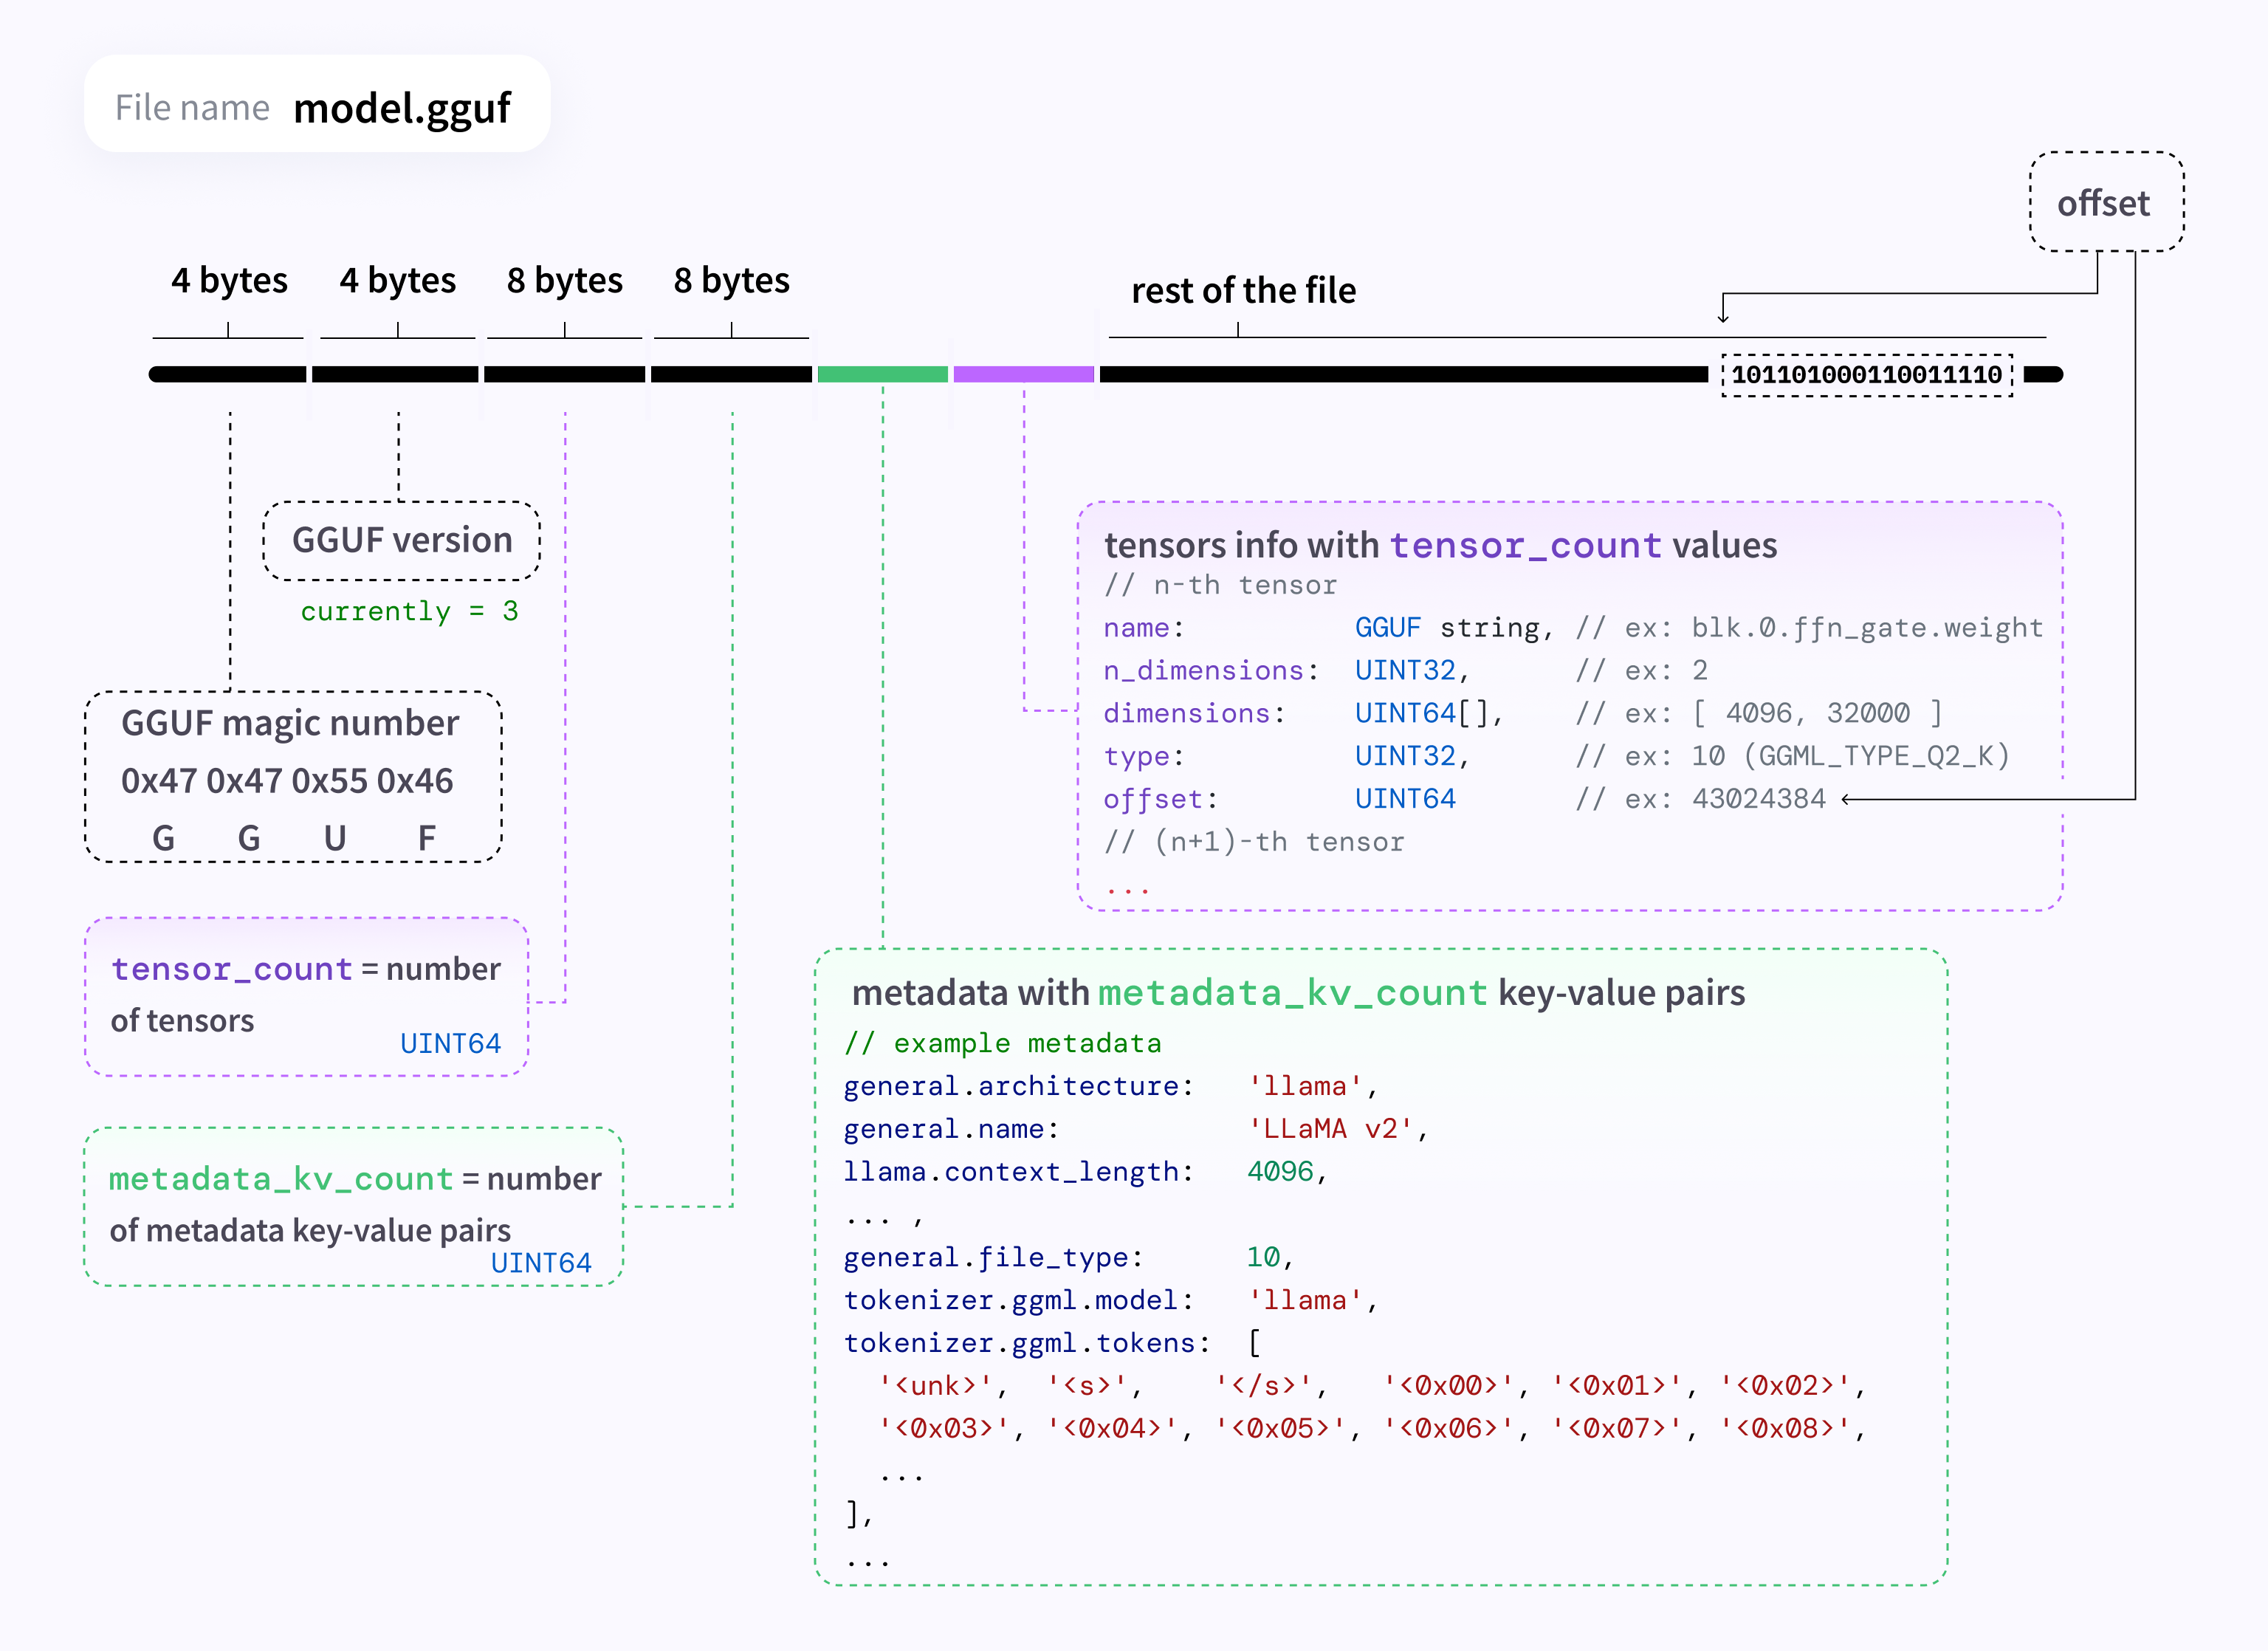

In [34]:
!pwd

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/xuananh/work/kaggle_gemma


In [35]:
!git clone https://github.com/ggerganov/llama.cpp.git
%cd llama.cpp
!make LLAMA_CUBLAS=1

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


fatal: destination path 'llama.cpp' already exists and is not an empty directory.
/home/xuananh/work/kaggle_gemma/llama.cpp


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


I ccache not found. Consider installing it for faster compilation.
expr: syntax error: unexpected argument ‘070100’
expr: syntax error: unexpected argument ‘080100’
I llama.cpp build info: 
I UNAME_S:   Linux
I UNAME_P:   x86_64
I UNAME_M:   x86_64
I CFLAGS:    -I. -Icommon -D_XOPEN_SOURCE=600 -D_GNU_SOURCE -DNDEBUG -DGGML_USE_CUDA -I/usr/local/cuda/include -I/usr/local/cuda/targets/x86_64-linux/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/xuananh/anaconda3/envs/code/include -std=c11   -fPIC -O3 -Wall -Wextra -Wpedantic -Wcast-qual -Wno-unused-function -Wshadow -Wstrict-prototypes -Wpointer-arith -Wmissing-prototypes -Werror=implicit-int -Werror=implicit-function-declaration -pthread -march=native -mtune=native -Wdouble-promotion -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/xuananh/anaconda3/envs/code/include
I CXXFLAGS:  -std=c++11 -fPIC -O3 -Wall -Wextra -Wpedantic -Wcast-qual -Wno-unused

### CPU Only

In [36]:
%%bash
./main \
  -m $(./scripts/hf.sh --repo janhq/Vistral-7b-Chat-GGUF --file vitral-7b-chat.Q4_K_M.gguf) \
  -p "Viết một đoạn văn dài 50 từ về VietAI là tổ chức phi lợi nhuận với sứ mệnh ươm mầm tài năng AI và xây dựng cộng đồng chuyên gia AI đẳng cấp thế giới tại Việt Nam." \
  -n 2048

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[+] attempting to download vitral-7b-chat.Q4_K_M.gguf
[+] wget -q --show-progress -c -O ./vitral-7b-chat.Q4_K_M.gguf https://huggingface.co/janhq/Vistral-7b-Chat-GGUF/resolve/main/vitral-7b-chat.Q4_K_M.gguf
./main: error while loading shared libraries: libcublas.so.12: cannot open shared object file: No such file or directory


CalledProcessError: Command 'b'./main \\\n  -m $(./scripts/hf.sh --repo janhq/Vistral-7b-Chat-GGUF --file vitral-7b-chat.Q4_K_M.gguf) \\\n  -p "Vi\xe1\xba\xbft m\xe1\xbb\x99t \xc4\x91o\xe1\xba\xa1n v\xc4\x83n d\xc3\xa0i 50 t\xe1\xbb\xab v\xe1\xbb\x81 VietAI l\xc3\xa0 t\xe1\xbb\x95 ch\xe1\xbb\xa9c phi l\xe1\xbb\xa3i nhu\xe1\xba\xadn v\xe1\xbb\x9bi s\xe1\xbb\xa9 m\xe1\xbb\x87nh \xc6\xb0\xc6\xa1m m\xe1\xba\xa7m t\xc3\xa0i n\xc4\x83ng AI v\xc3\xa0 x\xc3\xa2y d\xe1\xbb\xb1ng c\xe1\xbb\x99ng \xc4\x91\xe1\xbb\x93ng chuy\xc3\xaan gia AI \xc4\x91\xe1\xba\xb3ng c\xe1\xba\xa5p th\xe1\xba\xbf gi\xe1\xbb\x9bi t\xe1\xba\xa1i Vi\xe1\xbb\x87t Nam." \\\n  -n 2048\n'' returned non-zero exit status 127.

With CPU only, GGUF format can archieve 1.66t/s

### GPU Offload

In [ ]:
%%bash
./main \
  -m $(./scripts/hf.sh --repo janhq/Vistral-7b-Chat-GGUF --file vitral-7b-chat.Q4_K_M.gguf) \
  -p "Viết một đoạn văn dài 50 từ về VietAI là tổ chức phi lợi nhuận với sứ mệnh ươm mầm tài năng AI và xây dựng cộng đồng chuyên gia AI đẳng cấp thế giới tại Việt Nam." \
  -n 1024 \
  -ngl 50

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[+] attempting to download vitral-7b-chat.Q4_K_M.gguf
[+] wget -q --show-progress -c -O ./vitral-7b-chat.Q4_K_M.gguf https://huggingface.co/janhq/Vistral-7b-Chat-GGUF/resolve/main/vitral-7b-chat.Q4_K_M.gguf
bash: line 2: ./main: No such file or directory


CalledProcessError: Command 'b'./main \\\n  -m $(./scripts/hf.sh --repo janhq/Vistral-7b-Chat-GGUF --file vitral-7b-chat.Q4_K_M.gguf) \\\n  -p "Vi\xe1\xba\xbft m\xe1\xbb\x99t \xc4\x91o\xe1\xba\xa1n v\xc4\x83n d\xc3\xa0i 50 t\xe1\xbb\xab v\xe1\xbb\x81 VietAI l\xc3\xa0 t\xe1\xbb\x95 ch\xe1\xbb\xa9c phi l\xe1\xbb\xa3i nhu\xe1\xba\xadn v\xe1\xbb\x9bi s\xe1\xbb\xa9 m\xe1\xbb\x87nh \xc6\xb0\xc6\xa1m m\xe1\xba\xa7m t\xc3\xa0i n\xc4\x83ng AI v\xc3\xa0 x\xc3\xa2y d\xe1\xbb\xb1ng c\xe1\xbb\x99ng \xc4\x91\xe1\xbb\x93ng chuy\xc3\xaan gia AI \xc4\x91\xe1\xba\xb3ng c\xe1\xba\xa5p th\xe1\xba\xbf gi\xe1\xbb\x9bi t\xe1\xba\xa1i Vi\xe1\xbb\x87t Nam." \\\n  -n 1024 \\\n  -ngl 50\n'' returned non-zero exit status 127.

With full offloading to the GPU, the GGUF format can achieve 26.16t/s

## (Optional) Flash Attention

❗CAUTION: Only run when you have A100

`Flash Attention` is an attention algorithm used to reduce this problem and scale transformer-based models more efficiently, enabling faster training and inference.

Due to the Flash Attention only supports high-end GPU. In this notebook, we use `Xformers` as an alternative.

`Xformers` has the same approach as Flash Attention by optimize calculation to reduce `self-attention` bottleneck.

For further infomation please read at: [Xformers Github Repo](https://github.com/facebookresearch/xformers)

In [ ]:
# !pip install -U flash-attn --no-build-isolation

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 7.5 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 209.0 MB/s eta 0:00:00
  Created wheel for flash-attn: filename=flash_attn-2.5.7-cp38-cp38-linux_x86_64.whl size=120854590 sha256=ce19e55b4ceb7ed8d5df63a390b6a361954d26050a84144f0df6c2a799559be1
  Stored in directory: /tmp/pip-ephem-wheel-cache-hdm686ru/wheels/2b/b9/36/4a7ad541fb046dd6bf0ba197b8bdb3cbd4337358812f5c26de
Successfully built flash-attn


In [37]:
#import AutoModelForCausalLM 
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    'Viet-Mistral/Vistral-7B-Chat',
    torch_dtype=torch.float16, # change to torch.bfloat16 if you're using A100
    device_map="cuda:0",
    use_cache=True,
    token=hf_key,
    attn_implementation="flash_attention_2"
)

tokenizer = AutoTokenizer.from_pretrained(
    'Viet-Mistral/Vistral-7B-Chat',
    token=hf_key
)

# For using XFormers backend
# Huggingface's XFormers currently doesn't support Mistral architecture.
# model.enable_xformers_memory_efficient_attention()

Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.30s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [38]:
#@title Generate response
generate_response(text, model, tokenizer, system_prompt)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


GPU = NVIDIA RTX A5000. Max memory = 23.67 GB.
Memory reserved = 18.855 GB.
----------------------
Assistant:  VietAI là một tổ chức phi lợi nhuận tận tụy trong việc nuôi dưỡng tài năng trí tuệ nhân tạo (AI) và phát triển cộng đồng chuyên gia AI hàng đầu tại Việt Nam. Sứ mệnh của họ là thúc đẩy sự phát triển của ngành công nghiệp AI bằng cách cung cấp nền tảng giáo dục, cơ hội kết nối và nguồn lực quý giá cho những người đam mê AI đầy tham vọng. Thông qua các chương trình đào tạo, hội thảo và sự kiện, VietAI đang nỗ lực xây dựng một hệ sinh thái mạnh mẽ gồm các chuyên gia AI, những người sẽ đóng góp vào sự tiến bộ của lĩnh vực này và định hình tương lai của công nghệ.
----------------------
Generation Time:  11.138018608093262 seconds
Tokens per Second:  12.47977803691205


'VietAI là một tổ chức phi lợi nhuận tận tụy trong việc nuôi dưỡng tài năng trí tuệ nhân tạo (AI) và phát triển cộng đồng chuyên gia AI hàng đầu tại Việt Nam. Sứ mệnh của họ là thúc đẩy sự phát triển của ngành công nghiệp AI bằng cách cung cấp nền tảng giáo dục, cơ hội kết nối và nguồn lực quý giá cho những người đam mê AI đầy tham vọng. Thông qua các chương trình đào tạo, hội thảo và sự kiện, VietAI đang nỗ lực xây dựng một hệ sinh thái mạnh mẽ gồm các chuyên gia AI, những người sẽ đóng góp vào sự tiến bộ của lĩnh vực này và định hình tương lai của công nghệ.'

In [39]:
#@title Flush memory
del model

gc.collect()
torch.cuda.empty_cache()

gc.collect()
torch.cuda.empty_cache()

: 